In [28]:
# General imports
import sys
sys.path.append("..")

import numpy as np
from numpy import argmax
import json
from matplotlib import pyplot

params = {
         'font.size': '14',
         'legend.fontsize': 'x-large',
         'figure.figsize': (12, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pyplot.rcParams.update(params)

In [29]:
pyplot.rcParams.keys()


KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.gri

## Load data

In [30]:
split_data = []
for i in range(5):
    data_path = f'../../artifacts/lr_baselines/x_nokc_hard/s888-{i}_bundle_i_icA_icA_TW_icW_icW_TW_n_gram_tcA_tcA_TW_tcW_tcW_TW_user_avg_correct.json'
    with open(data_path, 'r') as f:
        data = json.load(f)
        split_data.append({
            'fpr': data['metrics_test']['fpr_curve'],
            'tpr': data['metrics_test']['tpr_curve'],
            'roc_t': data['metrics_test']['roc_opt_t'],
            'j_best_i': data['metrics_test']['J_best_i'],
            'precision': data['metrics_test']['precision_curve'],
            'recall': data['metrics_test']['recall_curve'],
            'pr_t': data['metrics_test']['pr_opt_t'],
            'fscore_best_i': data['metrics_test']['fscore_best_i'],
            'cm': data['metrics_test']['cm'],
            'cm_roc_opt': data['metrics_test']['cm_roc_opt']
        })

In [31]:
def average_curves(xps, fps, zero=True):
    max_len = 0
    for i in range(len(xps)):
        max_len = max(max_len, len(xps[i]))

    mean_x = np.linspace(0, 1, max_len)
    interp_fps = []

    for i in range(len(xps)):
        xp = xps[i]
        fp = fps[i]
        interp_fp = np.interp(mean_x, xp, fp)
        if zero:
            interp_fp[0] = 0
        interp_fps.append(interp_fp)

    mean_fp = np.mean(interp_fps, axis=0)
    if zero:
        mean_fp[-1] = 1.0

    return mean_x, mean_fp

### Average ROC Curves

In [32]:
fprs = [split_data[i]['fpr'] for i in range(5)]
tprs = [split_data[i]['tpr'] for i in range(5)]

mean_fpr, mean_tpr = average_curves(fprs, tprs)

In [33]:
best_threshold = np.mean([split_data[i]['roc_t'] for i in range(5)])
J = mean_tpr - mean_fpr
roc_ix = argmax(J)

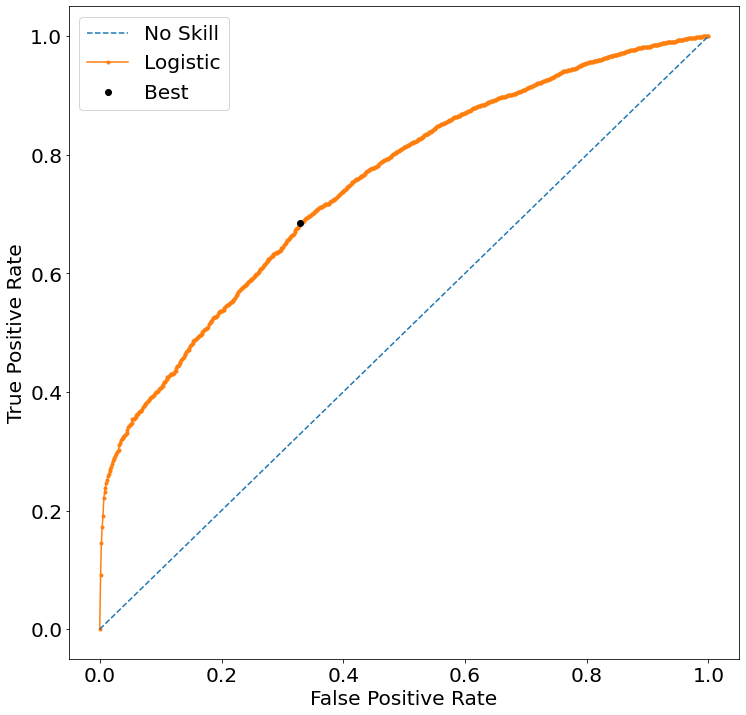

Best Threshold=60.42%


In [34]:
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(mean_fpr, mean_tpr, marker='.', label='Logistic', zorder=1)
pyplot.scatter(mean_fpr[roc_ix], mean_tpr[roc_ix], marker='o', color='black', label='Best', zorder=2)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
print(f'Best Threshold={best_threshold:.2%}')


### Average Precision-Recall Curve

In [35]:
def reverse_elem(elem):
    elem.reverse()
    return elem

In [36]:
recalls = [split_data[i]['recall'].copy() for i in range(5)]
prs = [split_data[i]['precision'].copy() for i in range(5)]
recalls = [reverse_elem(r) for r in recalls]
prs = [reverse_elem(p) for p in prs]
mean_recall, mean_precision = average_curves(recalls, prs, zero=False)
mean_recall = mean_recall[::-1]
mean_precision = mean_precision[::-1]

In [37]:
best_threshold = np.mean([split_data[i]['pr_t'] for i in range(5)])
# convert to f score
fscore = (2 * mean_precision * mean_recall) / (mean_precision + mean_recall)
# locate the index of the largest f score
ix = argmax(fscore)

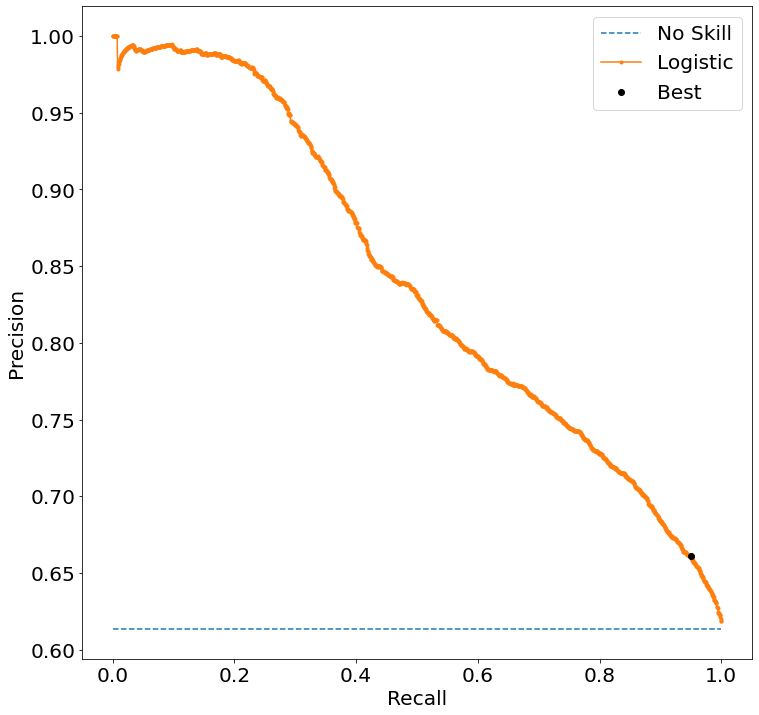

Best Threshold=36.82%, F-Score=77.94%


In [38]:
# plot the precision recall curve for the model
# no_skill = len(testy[testy==1]) / len(testy)
no_skill = 0.613296
 # baseline correct
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', zorder=1)
pyplot.plot(mean_recall, mean_precision, marker='.', label='Logistic', zorder=2)
pyplot.scatter(mean_recall[ix], mean_precision[ix], marker='o', color='black', label='Best', zorder=3)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()
print(f'Best Threshold={best_threshold:.2%}, F-Score={fscore[ix]:.2%}')

## Confusion Matrix

## Threshold = 0.5

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
cm_sum = np.rint(np.sum([split_data[i]['cm'] for i in range(5)], axis=0))

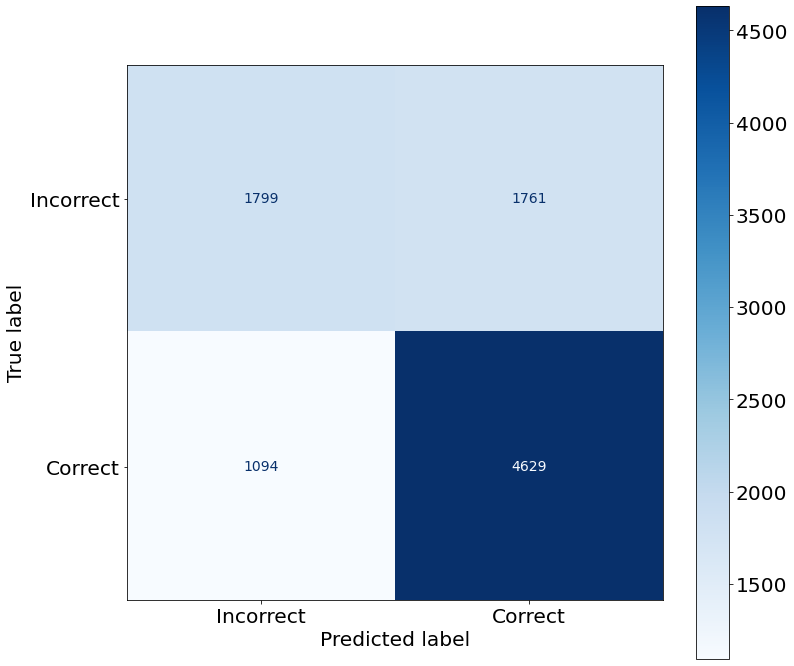

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sum, display_labels=["Incorrect", "Correct"])
disp.plot(cmap="Blues", values_format='g')
pyplot.show()

### Threshold based on Optimal AUCROC

In [42]:
cm_sum_roc = np.rint(np.sum([split_data[i]['cm_roc_opt'] for i in range(5)], axis=0))


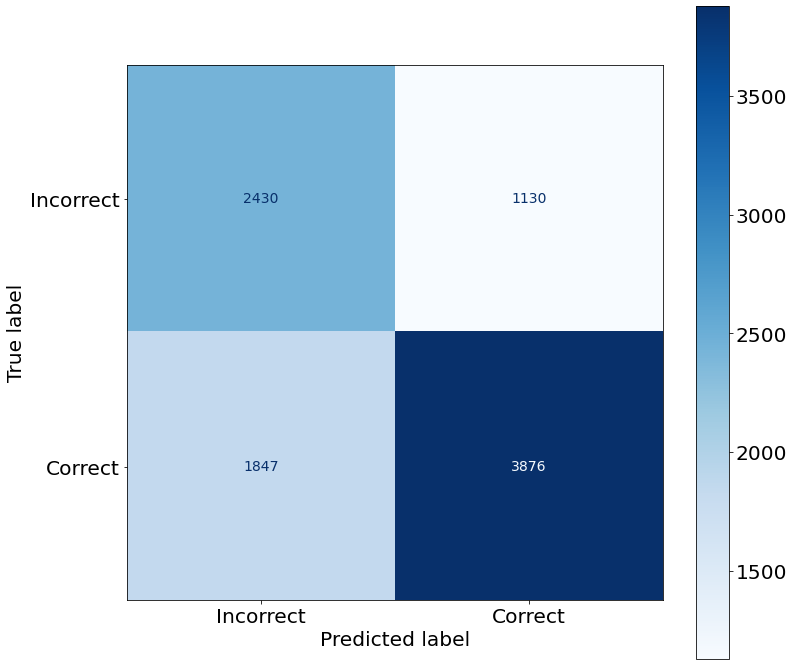

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sum_roc, display_labels=["Incorrect", "Correct"])
disp.plot(cmap="Blues", values_format='g')
pyplot.show()

